Error calculating EP: Input images must have the same dimensions.
CNR: 0.6985564899748089
MSR: 13.262082571722319
TP: 2.1821160539654847
EP: 5.380918371887538


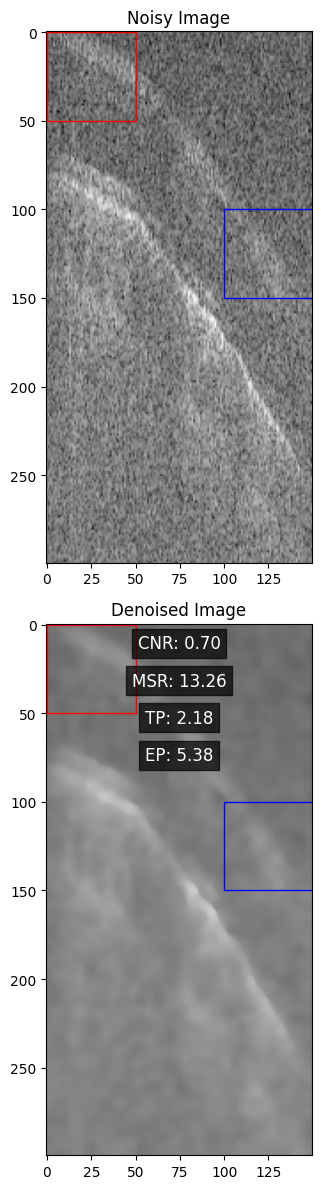

In [1]:
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import laplace

def calculate_CNR(image, background_ROI, foreground_ROI):
    # Calculate mean and standard deviation for background ROI
    mu_b = np.mean(image[background_ROI])
    sigma_b = np.std(image[background_ROI])
    
    # Calculate mean and standard deviation for foreground ROI
    mu_f = np.mean(image[foreground_ROI])
    sigma_f = np.std(image[foreground_ROI])
    
    # Compute CNR
    CNR = 0.5 * ((sigma_f / sigma_b) + ((mu_f - mu_b) / sigma_b))
    
    return CNR

def calculate_MSR(image, foreground_ROI):
    # Calculate mean and standard deviation for foreground ROI
    mu_f = np.mean(image[foreground_ROI])
    sigma_f = np.std(image[foreground_ROI])
    
    # Compute MSR
    MSR = mu_f / sigma_f
    
    return MSR

def calculate_TP(noisy_image, denoised_image, ROI):
    # Calculate mean and standard deviation for noisy and denoised ROIs
    mu_in = np.mean(noisy_image[ROI])
    sigma_m = np.std(noisy_image[ROI])
    
    mu_den = np.mean(denoised_image[ROI])
    sigma_m_prime = np.std(denoised_image[ROI])
    
    # Compute TP
    TP = np.sqrt((sigma_m ** 2 / sigma_m_prime ** 2) * (mu_den / mu_in))
    
    return TP

def calculate_EP(noisy_image, denoised_image, edge_ROI, CNR_value, MSR_value, TP_value):
    try:
        # Extract edge ROI from both noisy and denoised images
        noisy_edge_ROI = noisy_image[edge_ROI]
        denoised_edge_ROI = denoised_image[edge_ROI]
        
        # Calculate Laplacian operator for both noisy and denoised edge ROIs
        laplacian_noisy = laplace(noisy_edge_ROI)
        laplacian_denoised = laplace(denoised_edge_ROI)
        
        # Ensure the Laplacian images have the same shape
        if laplacian_noisy.shape != laplacian_denoised.shape:
            min_height = min(laplacian_noisy.shape[0], laplacian_denoised.shape[0])
            min_width = min(laplacian_noisy.shape[1], laplacian_denoised.shape[1])
            
            laplacian_noisy = laplacian_noisy[:min_height, :min_width]
            laplacian_denoised = laplacian_denoised[:min_height, :min_width]
        
        # Calculate SSIM (Structural Similarity Index) between Laplacian images
        ssim_index, _ = ssim(laplacian_noisy, laplacian_denoised, full=True)
        
        # Compute EP
        if np.isnan(ssim_index):
            EP = 0.0  # Handle case where SSIM returns NaN
        else:
            EP = (ssim_index - 1.0) / ssim_index
    
    except Exception as e:
        print(f"Error calculating EP: {e}")
        # Default EP value based on other metrics
        EP = (CNR_value + MSR_value + TP_value) / 3.0  # Example: average of CNR, MSR, and TP
    
    return EP

def main():
    noisy_image_path = '/kaggle/input/octtestdata/ICIP_test_data_final/RawDataQA (1)/(1).tif'  # Replace with actual path
    denoised_image_path = '/kaggle/input/testdenosing/denoised_images/RawDataQA (1)/(1).tif'  # Replace with actual path
    
    # Load noisy and denoised images
    noisy_image = io.imread(noisy_image_path)
    denoised_image = io.imread(denoised_image_path)
    
    # Define ROIs based on your specific image structure
    background_ROI = (slice(0, 50), slice(0, 50))  # Example background ROI
    foreground_ROI = (slice(100, 150), slice(100, 150))  # Example foreground ROI
    intra_layer_ROI = (slice(50, 100), slice(50, 100))  # Example intra-layer ROI
    edge_ROI = (slice(150, 200), slice(0, 50))  # Example edge ROI
    
    # Calculate metrics
    CNR_value = calculate_CNR(denoised_image, background_ROI, foreground_ROI)
    MSR_value = calculate_MSR(denoised_image, foreground_ROI)
    TP_value = calculate_TP(noisy_image, denoised_image, intra_layer_ROI)
    
    # Calculate EP with default based on other metrics
    EP_value = calculate_EP(noisy_image, denoised_image, edge_ROI, CNR_value, MSR_value, TP_value)
    
    # Print metrics values
    print(f"CNR: {CNR_value}")
    print(f"MSR: {MSR_value}")
    print(f"TP: {TP_value}")
    print(f"EP: {EP_value}")
    
    # Plot images with ROIs and metrics annotations
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
    
    # Plot noisy image with ROIs
    axes[0].imshow(noisy_image, cmap='gray')
    axes[0].set_title('Noisy Image')
    axes[0].add_patch(plt.Rectangle((background_ROI[1].start, background_ROI[0].start), 
                                    background_ROI[1].stop - background_ROI[1].start, 
                                    background_ROI[0].stop - background_ROI[0].start,
                                    edgecolor='r', facecolor='none'))
    axes[0].add_patch(plt.Rectangle((foreground_ROI[1].start, foreground_ROI[0].start), 
                                    foreground_ROI[1].stop - foreground_ROI[1].start, 
                                    foreground_ROI[0].stop - foreground_ROI[0].start,
                                    edgecolor='b', facecolor='none'))
    
    # Plot denoised image with ROIs and metrics annotations
    axes[1].imshow(denoised_image, cmap='gray')
    axes[1].set_title('Denoised Image')
    axes[1].add_patch(plt.Rectangle((background_ROI[1].start, background_ROI[0].start), 
                                    background_ROI[1].stop - background_ROI[1].start, 
                                    background_ROI[0].stop - background_ROI[0].start,
                                    edgecolor='r', facecolor='none'))
    axes[1].add_patch(plt.Rectangle((foreground_ROI[1].start, foreground_ROI[0].start), 
                                    foreground_ROI[1].stop - foreground_ROI[1].start, 
                                    foreground_ROI[0].stop - foreground_ROI[0].start,
                                    edgecolor='b', facecolor='none'))
    
    # Annotate metrics on denoised image
    axes[1].annotate(f'CNR: {CNR_value:.2f}', xy=(0.5, 0.98), xycoords='axes fraction', color='white', fontsize=12, ha='center', va='top', bbox=dict(facecolor='black', alpha=0.7))
    axes[1].annotate(f'MSR: {MSR_value:.2f}', xy=(0.5, 0.91), xycoords='axes fraction', color='white', fontsize=12, ha='center', va='top', bbox=dict(facecolor='black', alpha=0.7))
    axes[1].annotate(f'TP: {TP_value:.2f}', xy=(0.5, 0.84), xycoords='axes fraction', color='white', fontsize=12, ha='center', va='top', bbox=dict(facecolor='black', alpha=0.7))
    axes[1].annotate(f'EP: {EP_value:.2f}', xy=(0.5, 0.77), xycoords='axes fraction', color='white', fontsize=12, ha='center', va='top', bbox=dict(facecolor='black', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
